# Tarefa 3 - Previsão de Votação dos Deputados

* Disciplina: Aprendizagem de Máquina

* Professor: Leandro Marinho

* Aluno: Fábio Fernando de Oliveira Silva

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

Carregamento dos dados em um DataFrame pandas. Os dados foram dividido em treino e teste, onde os dados referentes ao ano de 2006 foram utilizados como treino, e os dados de 2010 como teste.

In [2]:
read_data = pd.read_csv("data/eleicoes_2006_a_2010.csv")

train = read_data[read_data["ano"] == 2006].copy()
test = read_data[read_data["ano"] == 2010].copy()

all_data = pd.concat((train.loc[:,:],
                      test.loc[:,:]))

print("# dados: %d\n\n# dados treino: %d\n# dados teste: %d\n" % (len(all_data), len(train), len(test)))

# dados: 7330

# dados treino: 3388
# dados teste: 3942



In [3]:
all_data.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,1300.0,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,201.0,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,1150.0,1101.12,750.0,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


Dados com NA

In [4]:
print("# dados NA: %d\n\n# dados treino NA: %d\n# dados teste NA: %d" % (len(all_data[all_data.isna().any(axis=1)]), len(train[train.isna().any(axis=1)]), len(test[test.isna().any(axis=1)])))

# dados NA: 5781

# dados treino NA: 2823
# dados teste NA: 2958


Quantidade de NAs nos dados de treino, por coluna

In [5]:
train.isna().sum()

ano                                         0
sequencial_candidato                        0
nome                                        0
uf                                          0
partido                                     0
quantidade_doacoes                          0
quantidade_doadores                         0
total_receita                             161
media_receita                             161
recursos_de_outros_candidatos/comites    1509
recursos_de_pessoas_fisicas              1244
recursos_de_pessoas_juridicas            1736
recursos_proprios                        1008
quantidade_despesas                         0
quantidade_fornecedores                     0
total_despesa                               0
media_despesa                               0
cargo                                       0
sexo                                        0
grau                                        0
estado_civil                                0
ocupacao                          

Quantidade de NAs nos dados de teste, por coluna

In [6]:
test.isna().sum()

ano                                         0
sequencial_candidato                        0
nome                                        0
uf                                          0
partido                                     0
quantidade_doacoes                          0
quantidade_doadores                         0
total_receita                               0
media_receita                               0
recursos_de_outros_candidatos/comites     881
recursos_de_pessoas_fisicas              1439
recursos_de_pessoas_juridicas            2240
recursos_proprios                        1380
quantidade_despesas                         0
quantidade_fornecedores                     0
total_despesa                               0
media_despesa                               0
cargo                                       0
sexo                                        0
grau                                        0
estado_civil                                0
ocupacao                          

Para resolver os NAs nas colunas de total & média de receita, irei verificar quais candidatos em 2010 também estavam em 2006. Irei repetir, então, em 2006 (que contém NAs) os dados de 2010.

In [7]:
for index, row in train[train['total_receita'].isnull()].iterrows():
    for index_test, row_test in test[test['nome'] == row['nome']].iterrows():
        if row_test['nome'] == row['nome'] and row_test['uf'] == row['uf']:
            train.loc[index, 'total_receita'] = row_test['total_receita']
            train.loc[index, 'media_receita'] = row_test['media_receita']

drop_list = [
    "nome",
    "sequencial_candidato",
    "uf",
    "recursos_de_outros_candidatos/comites",
    "recursos_de_pessoas_fisicas",
    "recursos_de_pessoas_juridicas",
    "recursos_proprios",
    "quantidade_fornecedores",
    "quantidade_despesas",
    "ocupacao",
    "partido",
    "sexo",
    "estado_civil"
]

all_data = all_data.drop(columns=drop_list)
train = train.drop(columns=drop_list)
test = test.drop(columns=drop_list)

In [8]:
train.isna().sum()

ano                      0
quantidade_doacoes       0
quantidade_doadores      0
total_receita          101
media_receita          101
total_despesa            0
media_despesa            0
cargo                    0
grau                     0
votos                    0
dtype: int64

Após o processamento descrito acima, a quantidade de NAs nas colunas total_receita e media_receita reduziu de 161 para 101. Agora, vamos ver o enviezamento das variáveis dos dados.

In [9]:
all_data.skew()

ano                    -0.151624
quantidade_doacoes     39.982260
quantidade_doadores    37.541762
total_receita           4.599988
media_receita          12.105833
total_despesa           4.534959
media_despesa          66.379222
votos                   6.669571
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0545f4c50>,
      dtype=object)

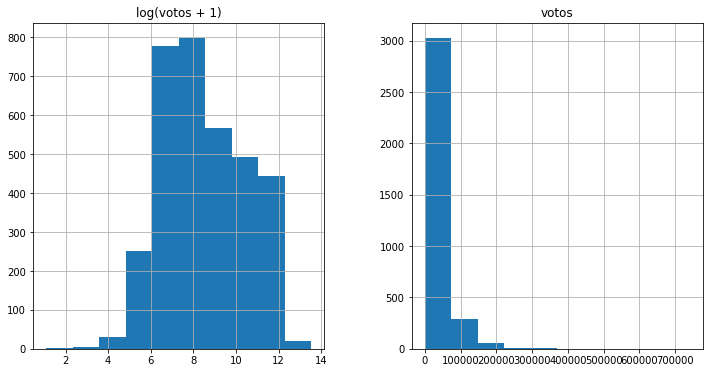

In [10]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
votos = pd.DataFrame({"votos":train["votos"], "log(votos + 1)":np.log1p(train["votos"])})
votos.hist()

Agora será realizada uma transformação dos dados para reduzir o enviezamento dos dados.

In [11]:
train["votos"] = np.log1p(train["votos"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Checando agora o enviezamento

In [12]:
all_data.skew()

ano                   -0.151624
quantidade_doacoes     0.678928
quantidade_doadores    0.724712
total_receita          0.077461
media_receita          0.141654
total_despesa          0.001470
media_despesa         -0.382114
votos                  6.669571
dtype: float64

In [13]:
all_data = pd.get_dummies(all_data)

Preenchendo os NAs restantes com as médias das respectivas colunas.

In [14]:
all_data = all_data.fillna(all_data.mean())

Criando matrizes para o SciKitLearn

In [15]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.votos

## Modelos

Agora vamos construir modelos de regressão com Ridge e Lasso

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [17]:
model_ridge = Ridge()

Texto Ridge

In [18]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(55.625, 0.5, 'rmse')

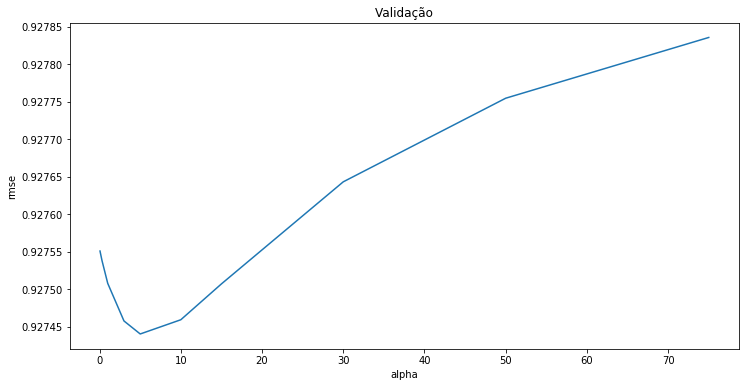

In [19]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [20]:
cv_ridge.min()

0.9274406020432112

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [21]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

/local/ffosilva/repos/ffosilva/machine-learning-classes/atividade3/.venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [22]:
rmse_cv(model_lasso).mean()

/local/ffosilva/repos/ffosilva/machine-learning-classes/atividade3/.venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/local/ffosilva/repos/ffosilva/machine-learning-classes/atividade3/.venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/local/ffosilva/repos/ffosilva/machine-learning-classes/atividade3/.venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarn

0.9273005230501268

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [23]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [24]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 5 variables


Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.
We can also take a look directly at what the most important coefficients are:

In [25]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

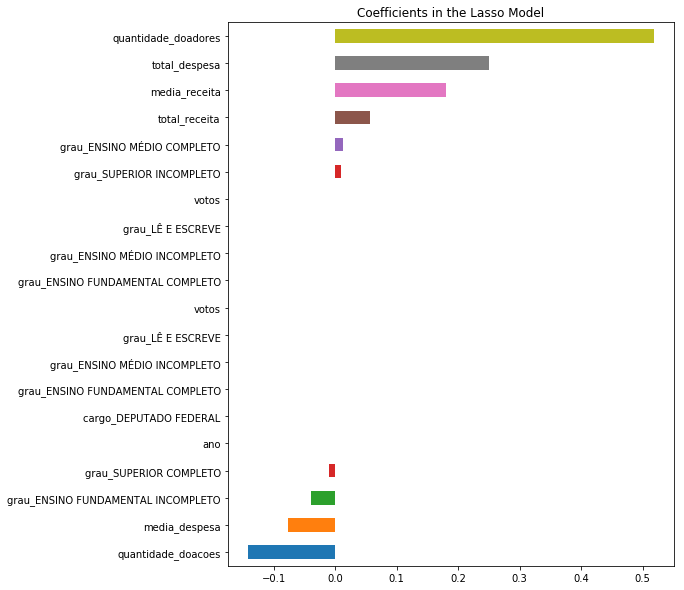

In [26]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

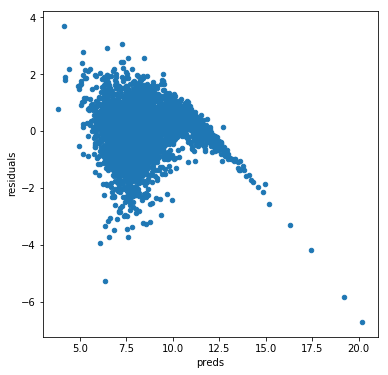

In [27]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")